In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import critical_loads as cl
import warnings

warnings.simplefilter('ignore')
plt.style.use('ggplot')

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database='critical_loads')

Connection successful.


# Critical loads: Vegetation workflow (high-resolution method; 2018 onwards)

In Spring 2018, the worflow for calculating critical loads was refined to make use of new, higher-resolution input datasets. During November 2018, data handling for the Critical Loads project was also redesigned, with the ultimate aim of centralising all key datasets on NIVA's new cloud platform. 

This notebook deals with data processing for the vegetation exceedance calculations, using the new 0.1 degree deposition grid and raster-based vegetation dataset. A brief description of the old vegetation datasets is also provided.

**Note:** Deposition data supplied prior to 2017-18 use a different spatial grid (the "BLR" grid), and prior to 2012 a different (vector-based) vegetation dataset was also used. **The workflow here only applies to data supplied from 2017-18 onwards**; earlier data is *not* compatible with the calculations in this notebook. 

## 1. Organising vegetation data on the DSToolkit

NIVA's JupyterHub includes a PostGIS database server capable of storing relational and vector geospatial datasets. I have created a database named `critical_loads` and, within this, a schema named `vegetation`. This schema contains the following tables:

 * **exceedance_stats_0_1deg_grid:** Non-spatial table containing the area and percent exceeded for each 0.1 degree grid cell
 
 * **exceedance_stats_blr_grid:** Non-spatial table containing the area and percent exceeded for each BLR grid cell
 
 * **exceedance_stats_land_class:** Non-spatial table containing the area and percent exceeded for each vegetation class in the raster vegetation dataset
 
 * **land_class_crit_lds:** Non-spatial table defining the critical loads for each vegetation class
 
 * **vector_veg_pre_2012:** The old vector vegetation dataset used prior to 2012

## 2. Define data series and resolution of interest

Choose the dataset you whish to work with (see notebook 01 for a list of available `series_ids`.

**Note:** If you want to work with the 30 m resolution data, you will need to **log-in on one of the high memory machines**, as the grids involved are large.

In [3]:
# Series of interest
ser_id = 28

# Choose cell size (30m, 60m or 120m)
cell_size = 120

## 3. Create raster of critical loads for vegetation (optional)

The code below reads the raster vegetation data and reclassifies it based on a table of critical loads. It is not necessary to re-run this step unless the critical loads for vegetation are changed. 

**Note:** The function `cl.reclassify_raster()` requires specification of a `mask_tif` to define the land. This is because the vegetation data includes offshore regions classified as `'water'`, and we do not wish to include these in the CL calculations. The `shared` drive includes three possible mask grids (30 m, 60 m and 120 m), all based on the extent of the old BLR grid.

### 3.1. Extract table of critical loads (optional)

In [4]:
## Read reclassification table from db
#sql = ("SELECT * FROM vegetation.land_class_crit_lds")
#rc_df = pd.read_sql(sql, eng)
#
## Set land class code as index
#rc_df.index = rc_df['norut_code']
#del rc_df['norut_code']
#
#rc_df

### 3.2. Reclassify vegetation dataset (optional)

In [5]:
## Reclassify
#mask_tif = f'/home/jovyan/shared/critical_loads/raster/blr_land_mask_{cell_size}m.tif'
#veg_tif = f'/home/jovyan/shared/critical_loads/raster/sat_veg_{cell_size}m_norut.tif'
#rc_tif = f'/home/jovyan/shared/critical_loads/raster/sat_veg_{cell_size}m_cl_100smgn_m2_yr.tif'
#cl.reclassify_raster(veg_tif,
#                     mask_tif,
#                     rc_tif,
#                     rc_df,
#                     'cl_100smgn_m2_yr',
#                     255)

## 4. Exceedances for vegetation

Exceedances for vegatation are calculated as follows:

 1. Read the raster of N deposition, which must already exist with the same properties (extent, cell size etc.) as the critical loads grid of interest here - see notebook 01
 
 2. Calculate the exceedance for each pixel, $i$, as $E_i = D_i - C_i$ (where $E$ is exceedance, $D$ is deposition and $C$ is the critical load)
 
 3. Save the exceedance grid as a GeoTiff. Calculate the total exceeded area for Norway as a whole, the proportion exceeded for each land class, and the proportion exceeded in each 0.1 degree vector cell
 
 4. Write summary results back to the database

In [6]:
# CL raster (created in Section 3.2)
cl_tif = f'/home/jovyan/shared/critical_loads/raster/sat_veg_{cell_size}m_cl_100smgn_m2_yr.tif'

# N deposition raster (created in notebook 01)
ndep_tif = f'/home/jovyan/shared/critical_loads/raster/deposition/ndep_mgpm2pyr_1216_{cell_size}m.tif'

# Output exceedance .tifs to create
ex_tif = f'/home/jovyan/shared/critical_loads/raster/exceedance/veg_ex_mgpm2pyr_1216_{cell_size}m.tif'
ex_tif_bool = f'/home/jovyan/shared/critical_loads/raster/exceedance/veg_ex_1216_{cell_size}m_bool.tif'

In [7]:
%%time

# Calculate exceedance
ex_df = cl.calc_vegetation_exceedance(ndep_tif, cl_tif, ex_tif, ex_tif_bool, ser_id)
ex_df

CPU times: user 4.75 s, sys: 1.9 s, total: 6.65 s
Wall time: 7.1 s


,series_id,medium,total_area_km2,exceeded_area_km2,exceeded_area_pct
0,28,vegetation,322184,61732,19


**If you connected to the database with `admin=True`**, these results can be saved back to the database.

In [8]:
## Write summary data to db
#ex_df.to_sql('national_summary', 
#             eng,
#             'summaries',
#             if_exists='append',
#             index=False)

## 5. Zonal statistics

To save results from the cells below, **you must be connected to the database with `admin=True`**. Otherwise, set `write_to_db=False` to read simply read the data.

### 5.1. Exceedance per 0.1 degree grid cell

The code below calculates exceedance summary statistics for each 0.1 degree grid cell.

In [9]:
# Calculate zonal statistics
gdf = cl.exceedance_stats_per_0_1deg_cell(ex_tif_bool, 
                                          ser_id, 
                                          eng, 
                                          categorical=True,
                                          category_map={1:'exceeded',
                                                        0:'not_exceeded'},
                                          nodata_value=255,
                                          write_to_db=False,
                                         )

gdf.head()

,geom,cell_id,series_id,exceeded_area_km2,total_area_km2,pct_exceeded
0,"MULTIPOLYGON (((5655.001 6470694.353, 5514.139...",58050655,28,0.1584,0.5328,29.729730
1,"MULTIPOLYGON (((9788.009 6465964.999, 9428.009...",58050665,28,5.8032,14.2416,40.748231
2,"MULTIPOLYGON (((17388.726 6469241.096, 17261.7...",58050675,28,15.1488,19.1376,79.157261
3,"MULTIPOLYGON (((22572.274 6462862.544, 22543.7...",58050685,28,9.4464,9.9360,95.072464
4,"MULTIPOLYGON (((27984.320 6458257.535, 27885.2...",58050695,28,21.1968,21.8736,96.905859


### 5.2. Exceedance per land use class

In [10]:
# Calc exceedance per land cover class
veg_tif = f'/home/jovyan/shared/critical_loads/raster/sat_veg_{cell_size}m_norut.tif'
df = cl.exceedance_stats_per_land_use_class(ex_tif_bool, 
                                            veg_tif, 
                                            ser_id,
                                            eng,
                                            nodata_value=255,
                                            write_to_db=False,
                                           )

df

,norut_code,series_id,exceeded_area_km2,total_area_km2,pct_exceeded
0,1,28,11642.8752,28658.8080,40.625818
1,2,28,6830.9712,16555.4496,41.261164
2,3,28,4206.0384,11402.7408,36.886205
3,4,28,1522.3104,18083.4912,8.418233
4,5,28,1176.5808,17783.9568,6.615967
5,6,28,3722.4720,14839.0848,25.085590
6,7,28,1741.5360,9021.6432,19.303978
7,8,28,1265.6160,6777.0720,18.674968
8,9,28,1408.0464,7998.2640,17.604400
9,10,28,222.0624,5938.5456,3.739340


### 5.3. Map exceedance per 0.1 degree grid square

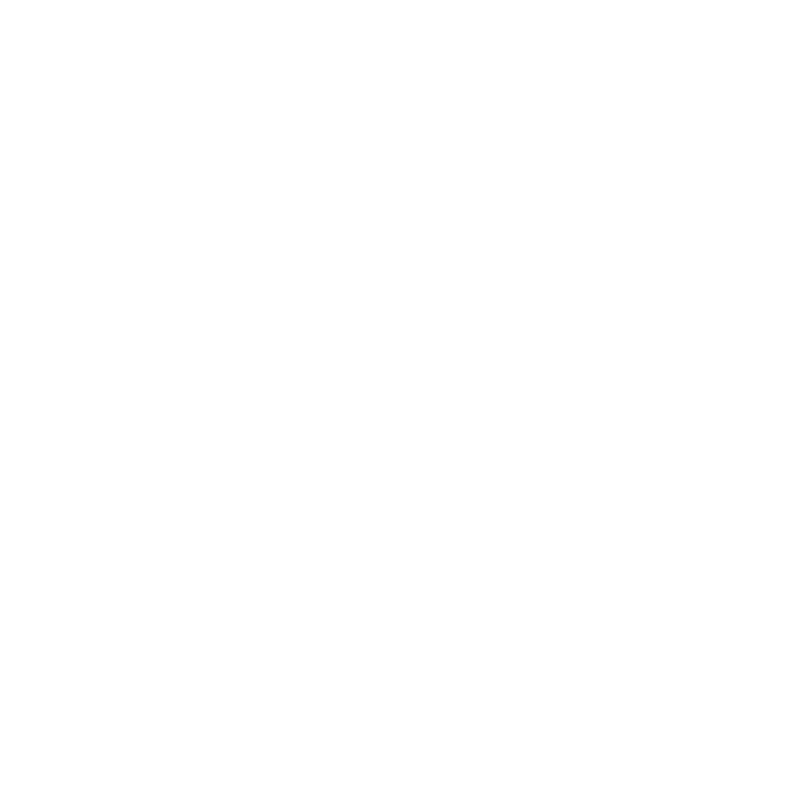

In [11]:
# Extract exceedance summaries
ex_gdf = cl.veg_exceedance_as_gdf_0_1deg(ser_id, eng)

# Choropleth map
ex_gdf.plot(column='pct_exceeded', 
            cmap='coolwarm',
            scheme='fisher_jenks',
            edgecolor=None,
            legend=True,
            legend_kwds={'loc':   'upper left',
                         'title': 'Vegetation exceedance (%)'},
            figsize=(8,8))

plt.axis('off')
plt.tight_layout()